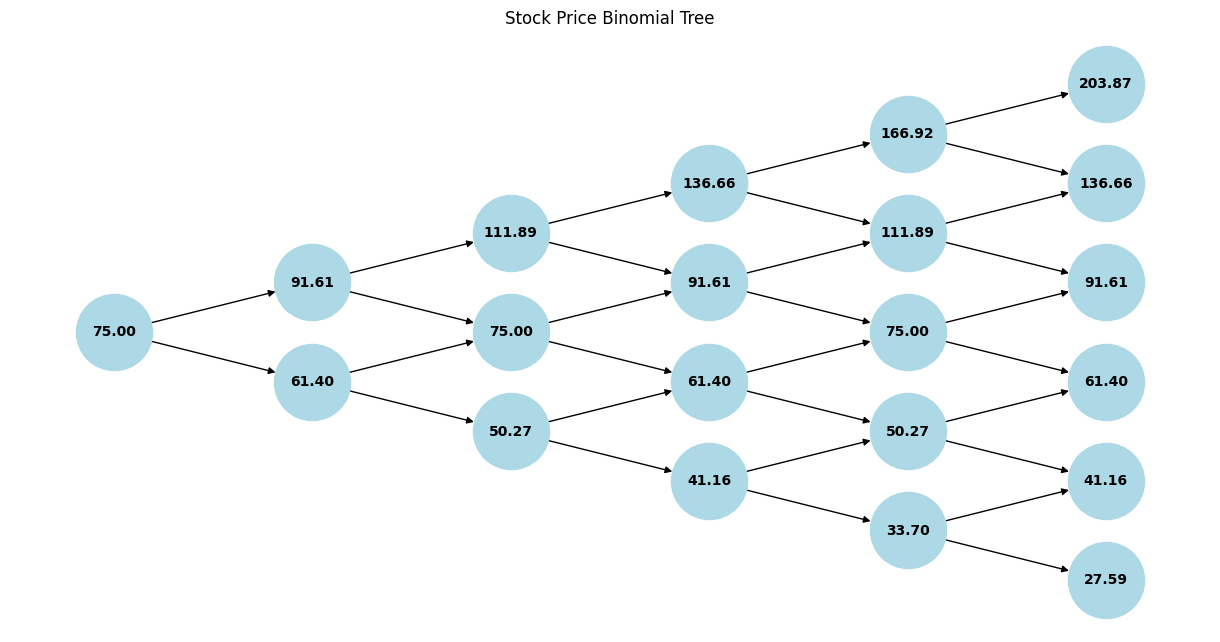

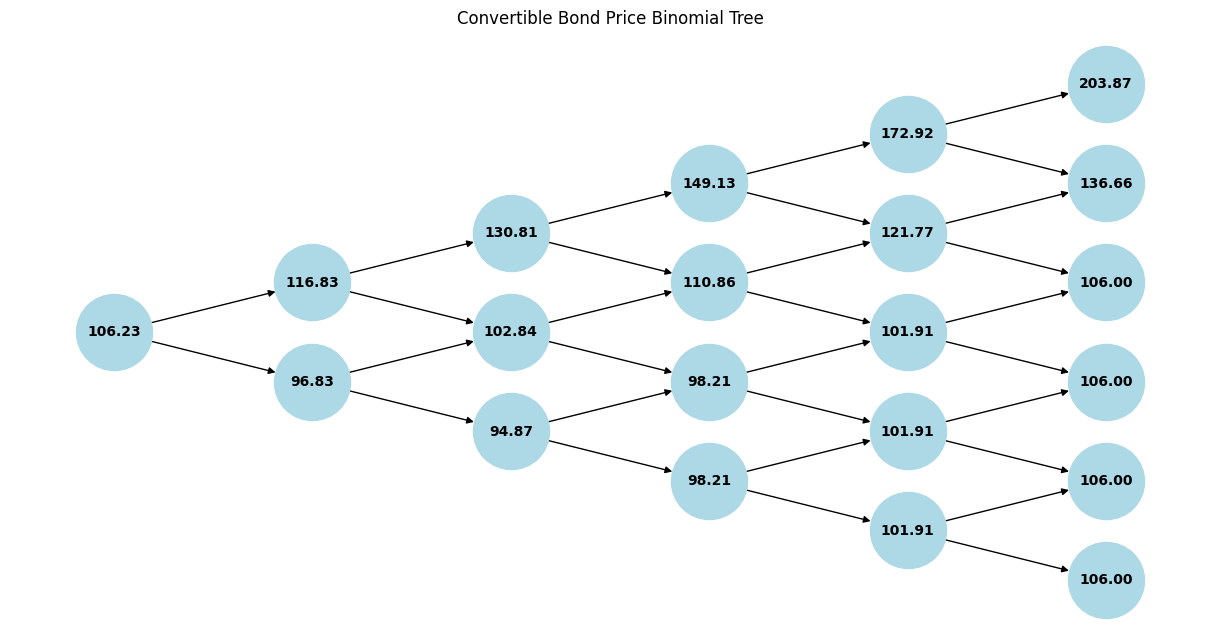

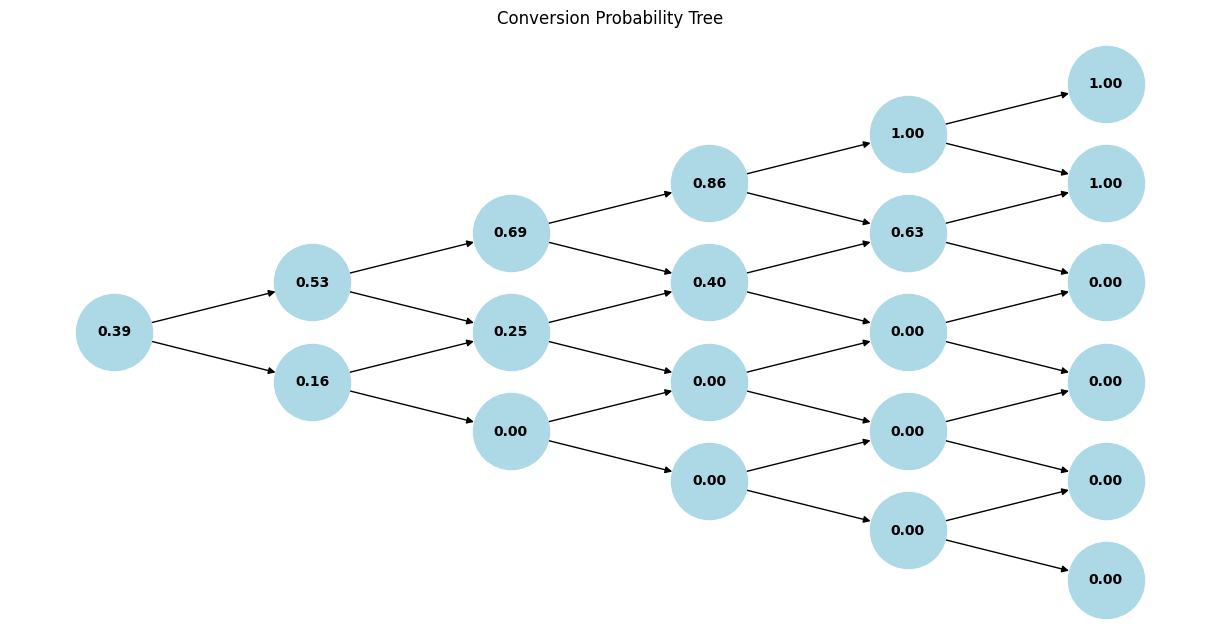

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm  

# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, steps, AmeEur='e'):
    # Time step
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))     # Up factor
    d = 1 / u                           # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((steps + 1, steps + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((steps + 1, steps + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(steps + 1):
        stock_price = stock_price_tree[j, steps]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        bond_price_tree[j, steps] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        conversion_prob_tree[j, steps] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(steps - 1, -1, -1):
        if CouponTime != (T - np.ceil((steps - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((steps - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Dynamic discount factors (ru, rd)
            ru = conversion_prob_tree[j+1, i+1] * r + (1 - conversion_prob_tree[j+1, i+1]) * (r + k)
            rd = conversion_prob_tree[j, i+1] * r + (1 - conversion_prob_tree[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Calculate bond price using backward induction
            hold_bond_value = CouponValue + p * bond_price_tree[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * bond_price_tree[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                conversion_prob_tree[j, i] = p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]

    return stock_price_tree, bond_price_tree, conversion_prob_tree
# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()
# Parameters
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
T = 5                               # Time to maturity (in years)
r = 0.07                            # Risk-free rate
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
steps = 5                           # Number of time steps
# Calculate the binomial trees
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")


In [64]:
# Function to compute u, d, and p based on different tree models
def calculate_tree_params(TreeType, sigma, dt, r, S, F, T, steps, b=0):
    if TreeType == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
    elif TreeType == 'Tian':
        eta = np.exp(dt * sigma ** 2)
        u = 0.5 * np.exp(r * dt) * eta * (eta + 1 + np.sqrt(eta ** 2 + 2 * eta - 3))
        d = 0.5 * np.exp(r * dt) * eta * (eta + 1 - np.sqrt(eta ** 2 + 2 * eta - 3))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'EQP':
        u = np.exp(((b) - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt))
        d = np.exp(((b) - sigma ** 2 / 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif TreeType == 'JR':
        u = np.exp(((b) - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt))
        d = np.exp(((b) - sigma ** 2 / 2) * dt - sigma * np.sqrt(dt))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'CRRdrift':
        eta = (np.log(F) - np.log(S)) / T
        u = np.exp(eta * dt + sigma * np.sqrt(dt))
        d = np.exp(eta * dt - sigma * np.sqrt(dt))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'LR_1' or TreeType == 'LR_2':
        d1 = (np.log(S / F) + ((b + sigma ** 2 / 2)) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        ptilde = norm.cdf(d1)
        p = norm.cdf(d2)
        u = np.exp(b * dt) * (ptilde / p)
        d = (np.exp(b * dt) - p * u) / (1 - p)
    elif TreeType == 'Haahtela':
        u = np.exp(np.sqrt(np.exp(sigma ** 2 * dt) - 1) + np.exp(b * dt) * dt)
        d = np.exp(-np.sqrt(np.exp(sigma ** 2 * dt) - 1) + np.exp(b * dt) * dt)
        p = (np.exp(b * dt) - d) / (u - d)
    else:
        raise ValueError("Invalid TreeType specified.")
    
    return u, d, p

# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, steps, TreeType='CRR', AmeEur='e'):
    dt = T / steps  # Time step

    # Compute u, d, and p based on the specified tree type
    u, d, p = calculate_tree_params(TreeType, sigma, dt, r, S0, F, T, steps)

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((steps + 1, steps + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((steps + 1, steps + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(steps + 1):
        stock_price = stock_price_tree[j, steps]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        bond_price_tree[j, steps] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        conversion_prob_tree[j, steps] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Backward calculation for bond price and conversion probability
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Calculate bond price using backward induction
            hold_bond_value = coupon + p * bond_price_tree[j + 1, i + 1] * np.exp(-r * dt) + (1 - p) * bond_price_tree[j, i + 1] * np.exp(-r * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                conversion_prob_tree[j, i] = p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]

    return stock_price_tree, bond_price_tree, conversion_prob_tree

# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}

    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i + 1},{j}")
                G.add_edge(node, f"{i + 1},{j + 1}")

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()


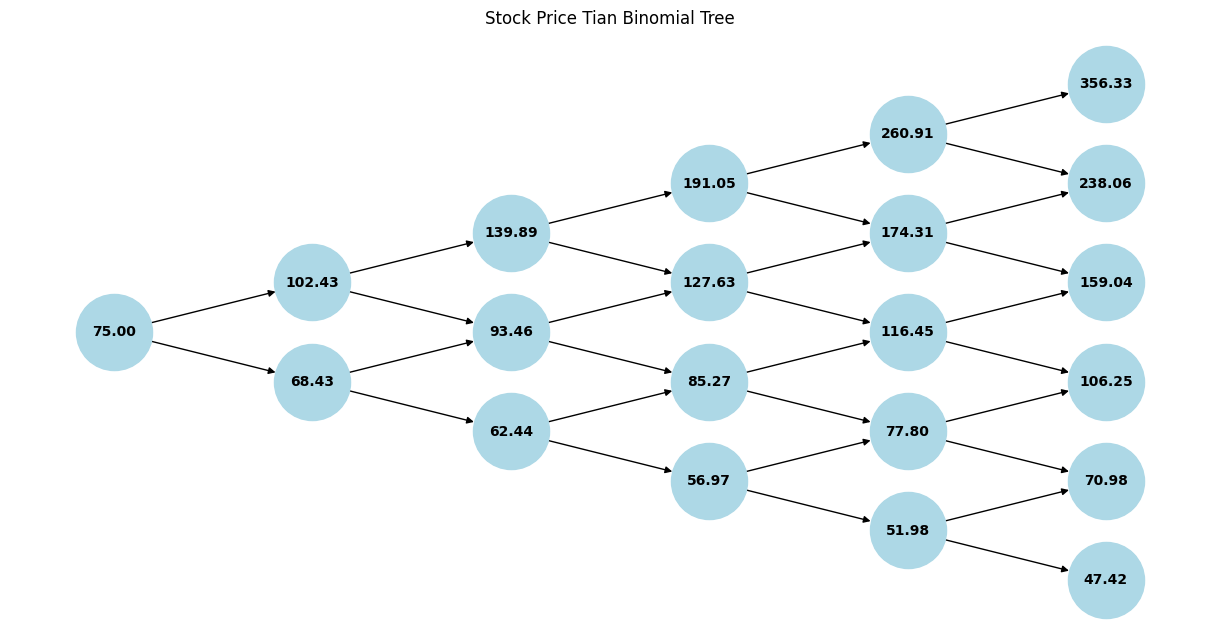

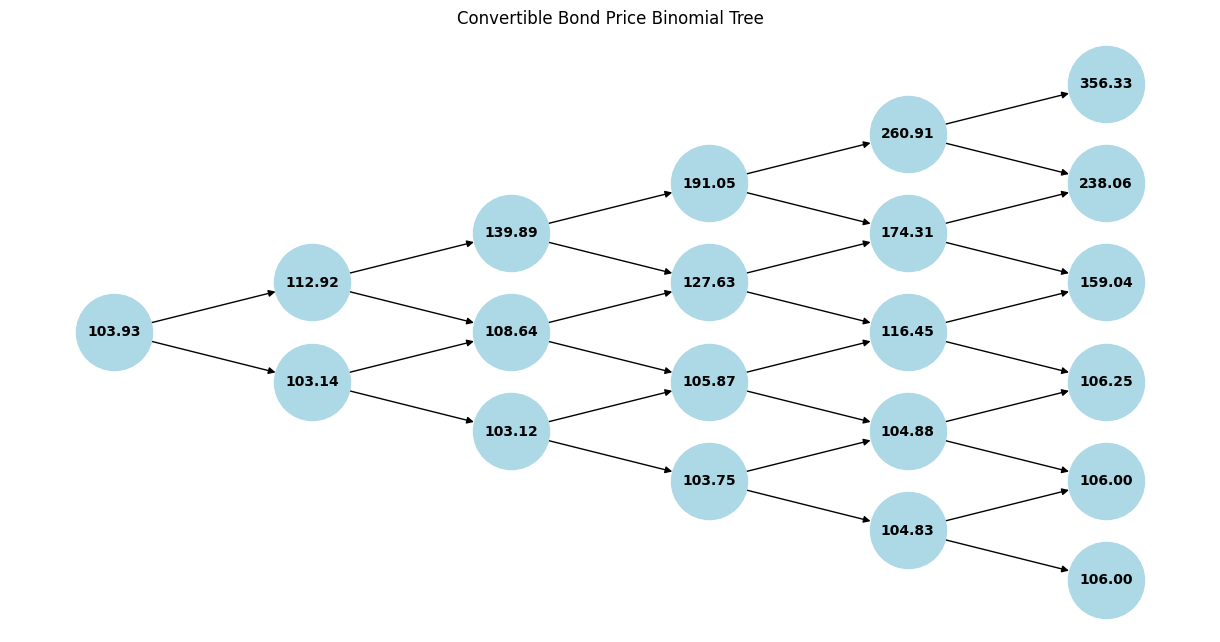

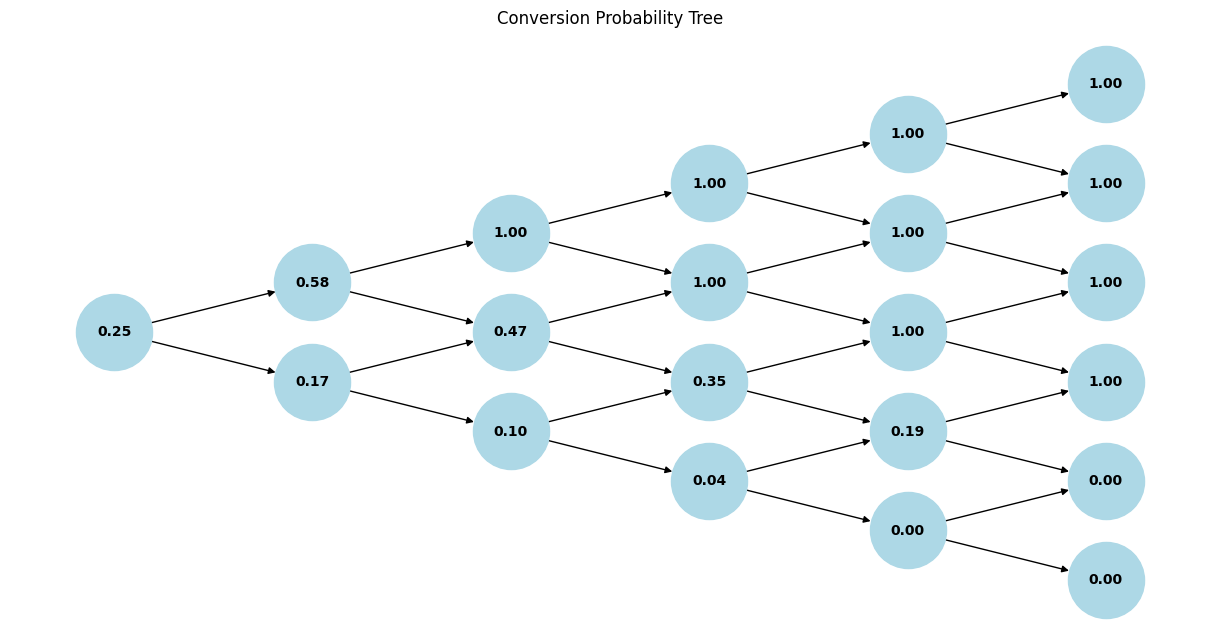

In [65]:
TreeType = 'Tian'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Tian Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

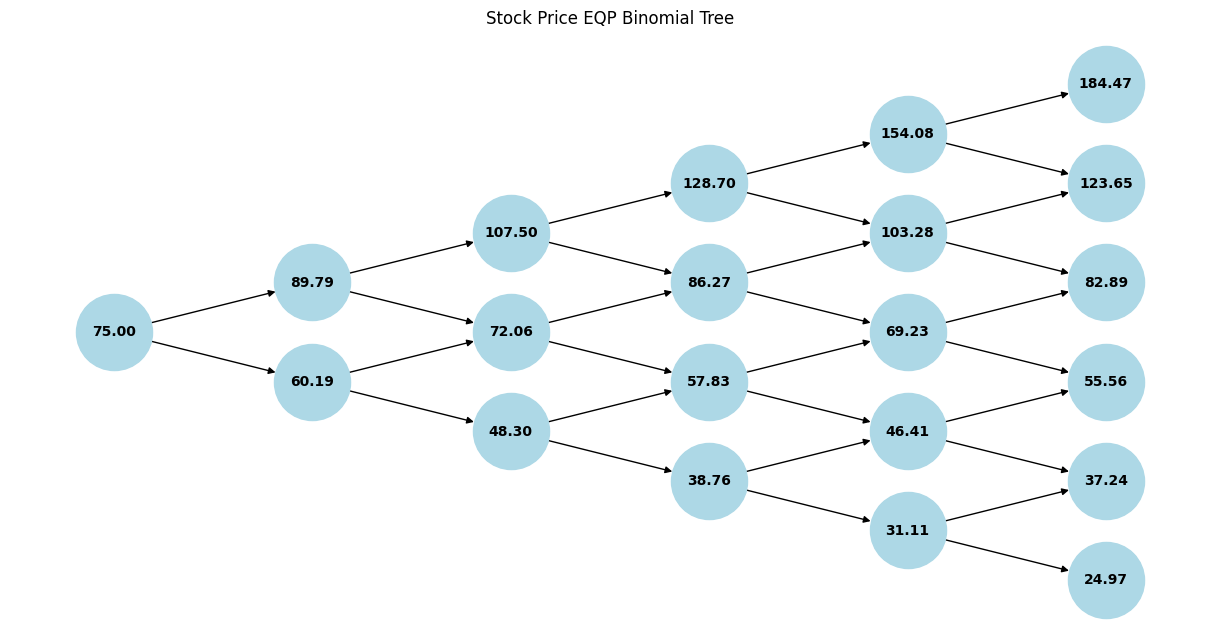

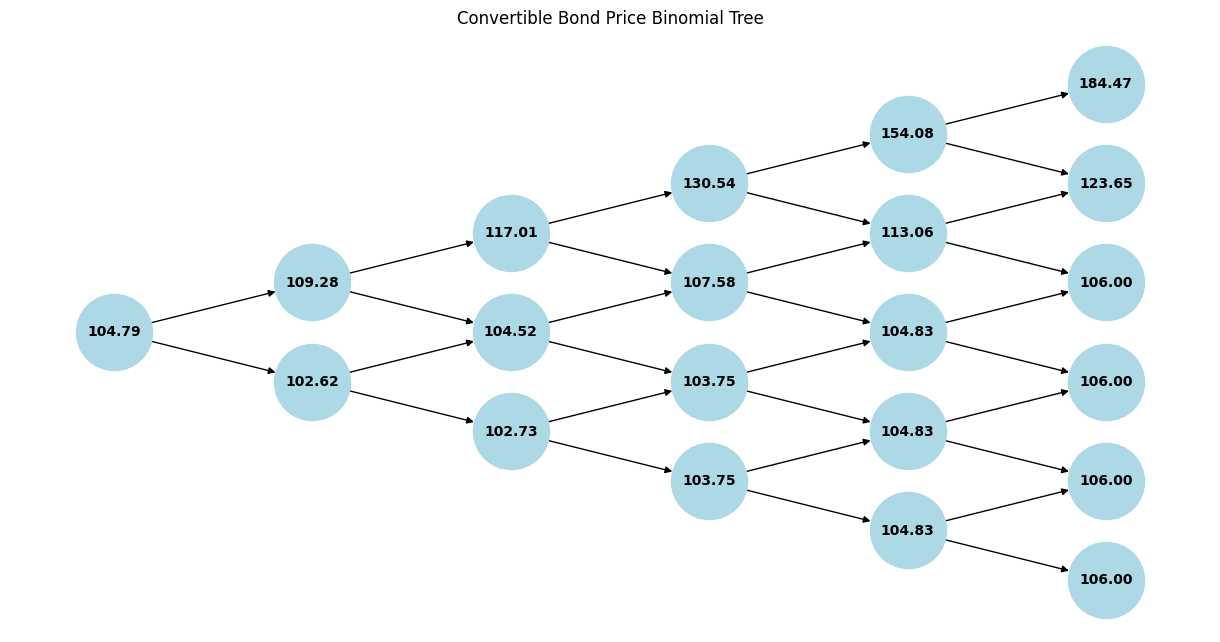

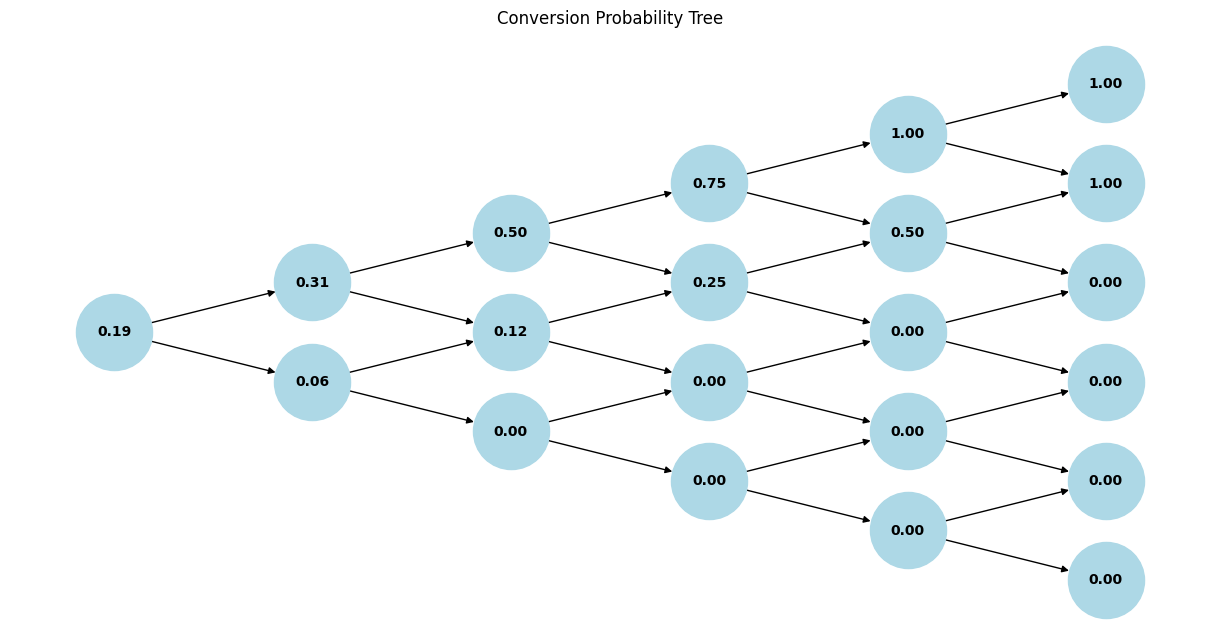

In [66]:
TreeType = 'EQP'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price EQP Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

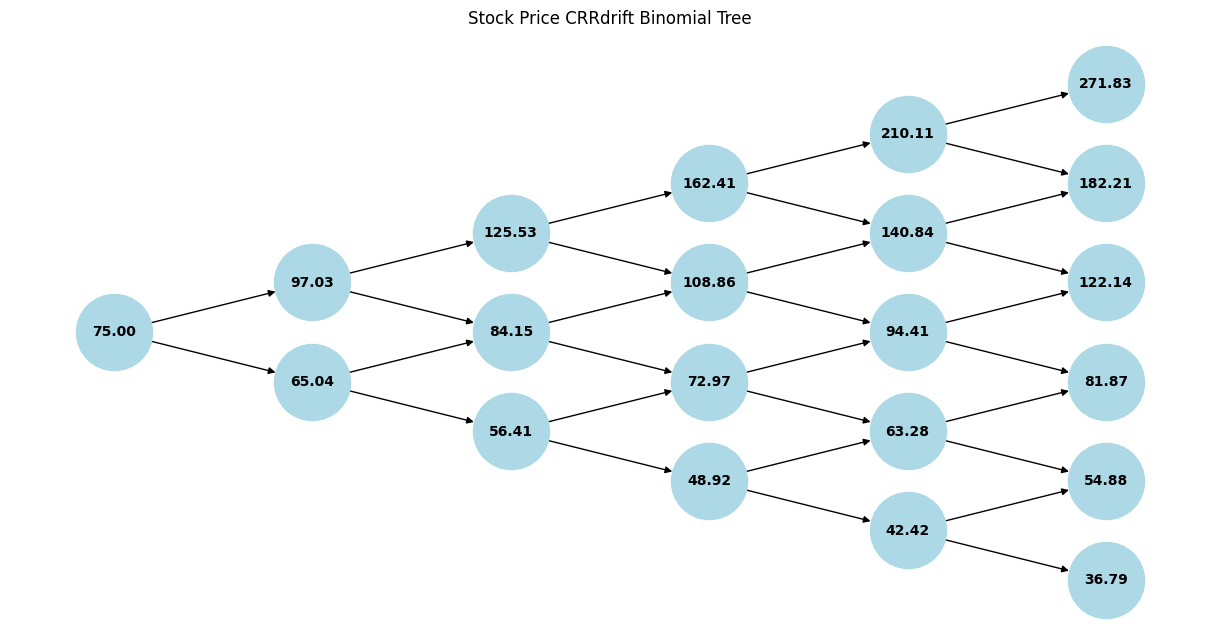

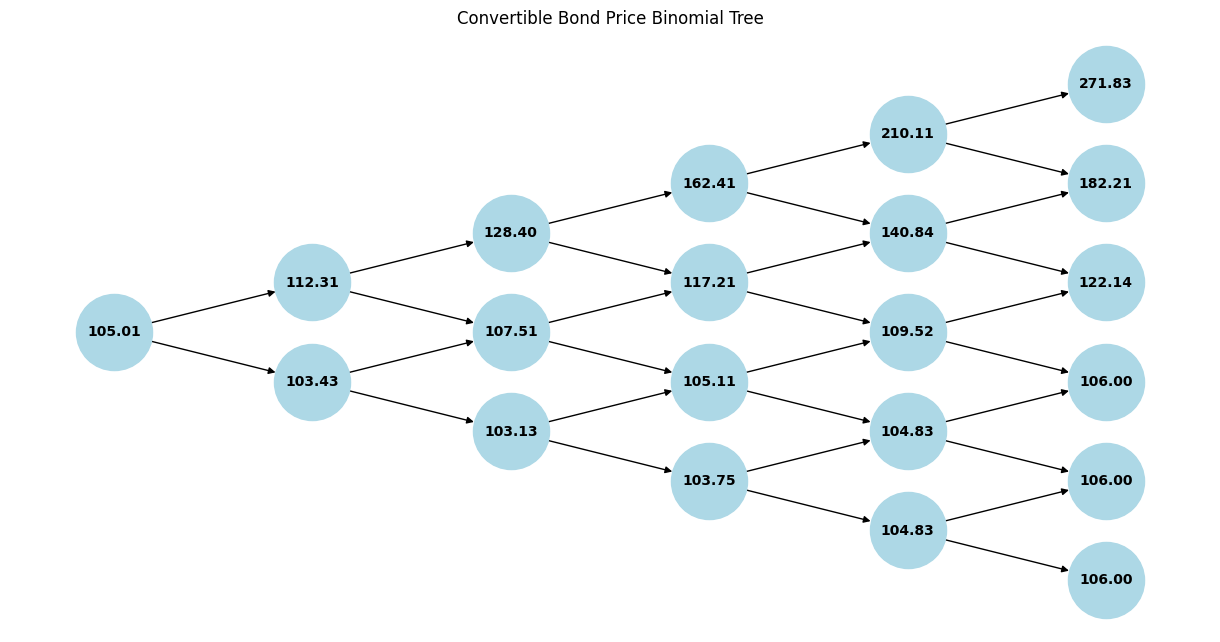

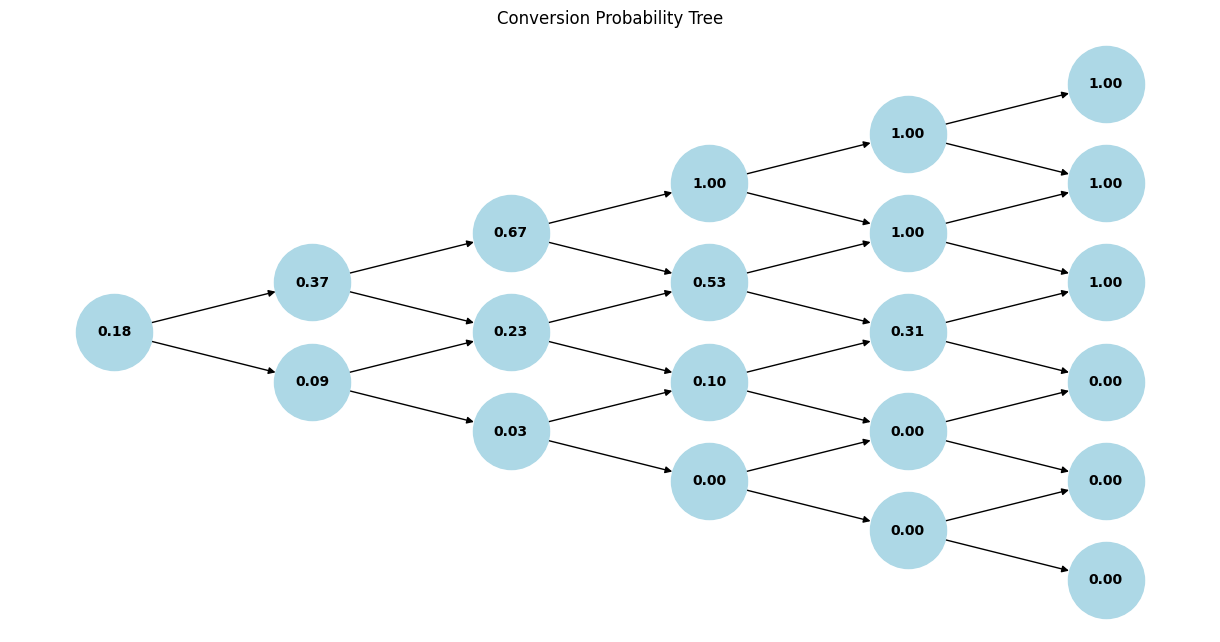

In [67]:
TreeType = 'CRRdrift'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price CRRdrift Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

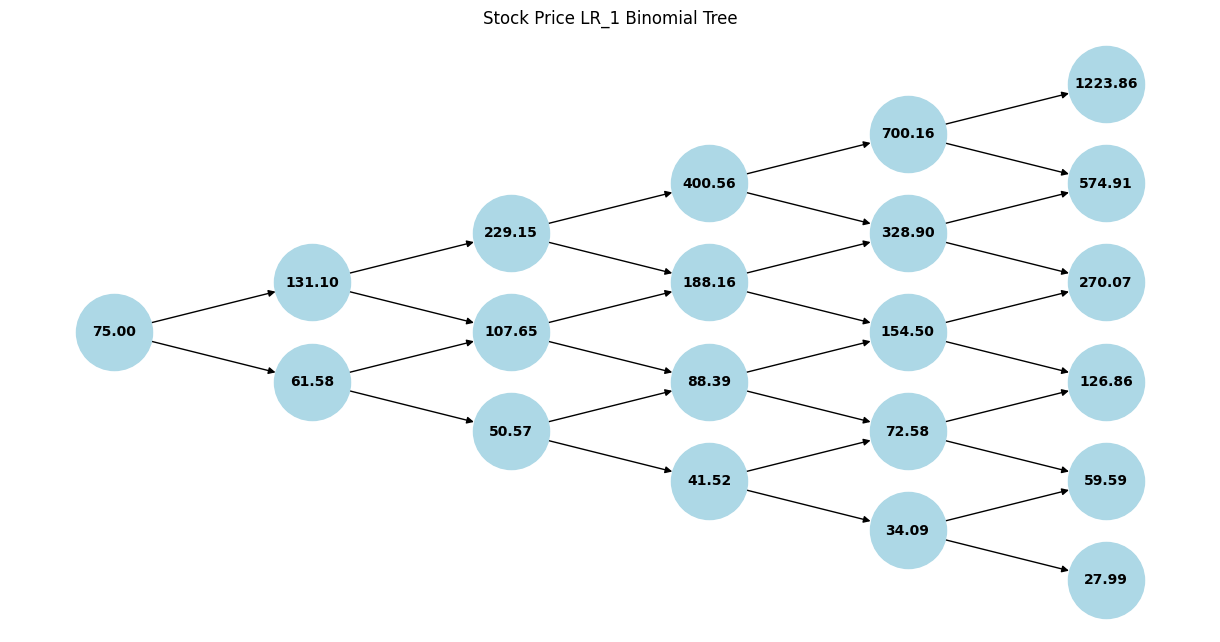

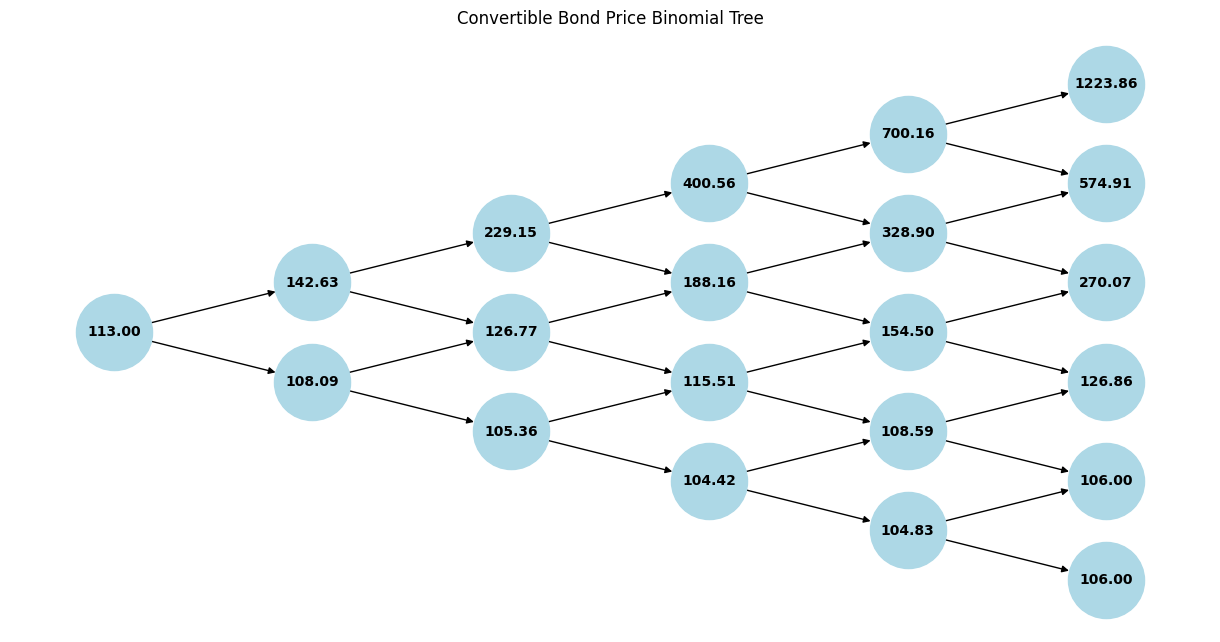

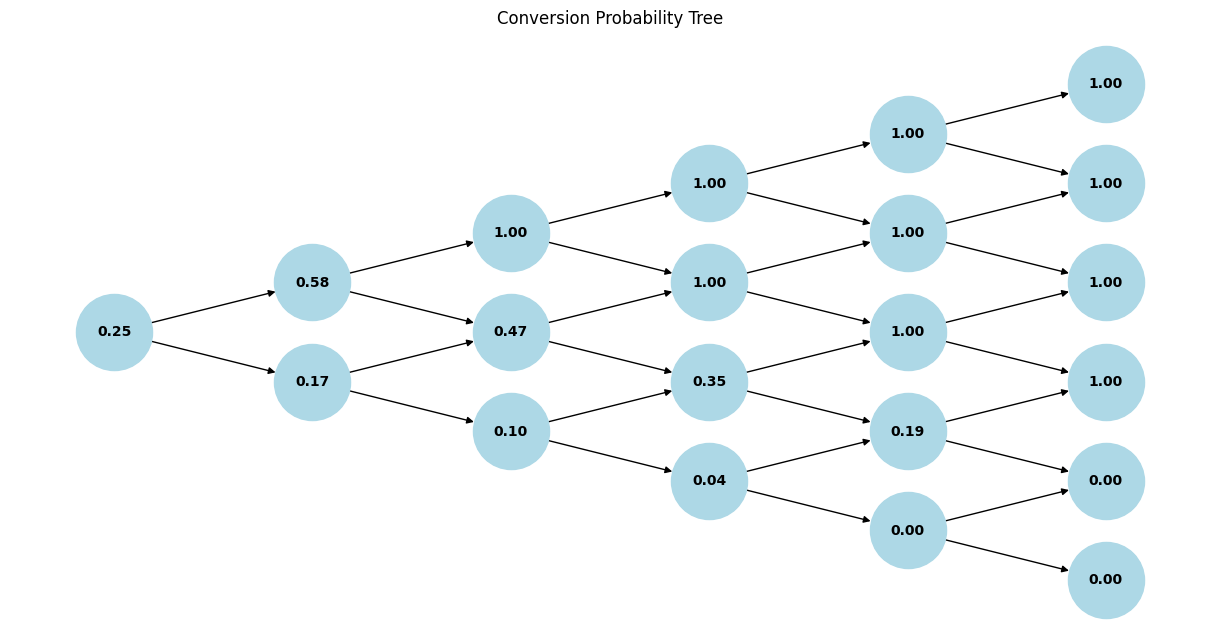

In [68]:
TreeType = 'LR_1'            

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price LR_1 Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

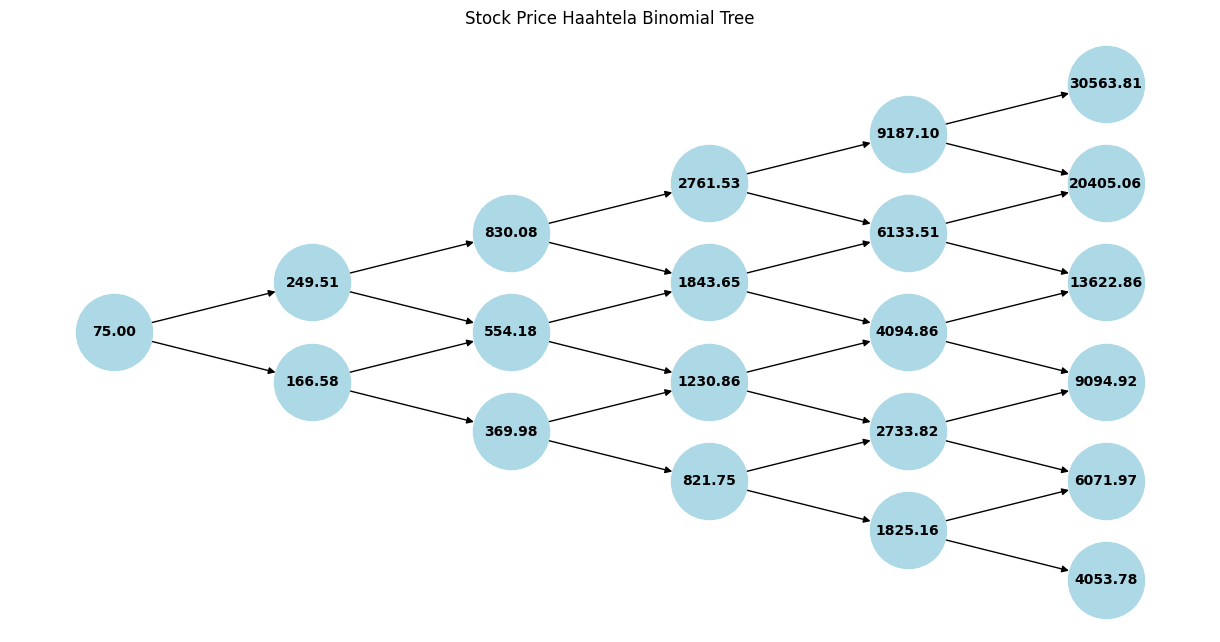

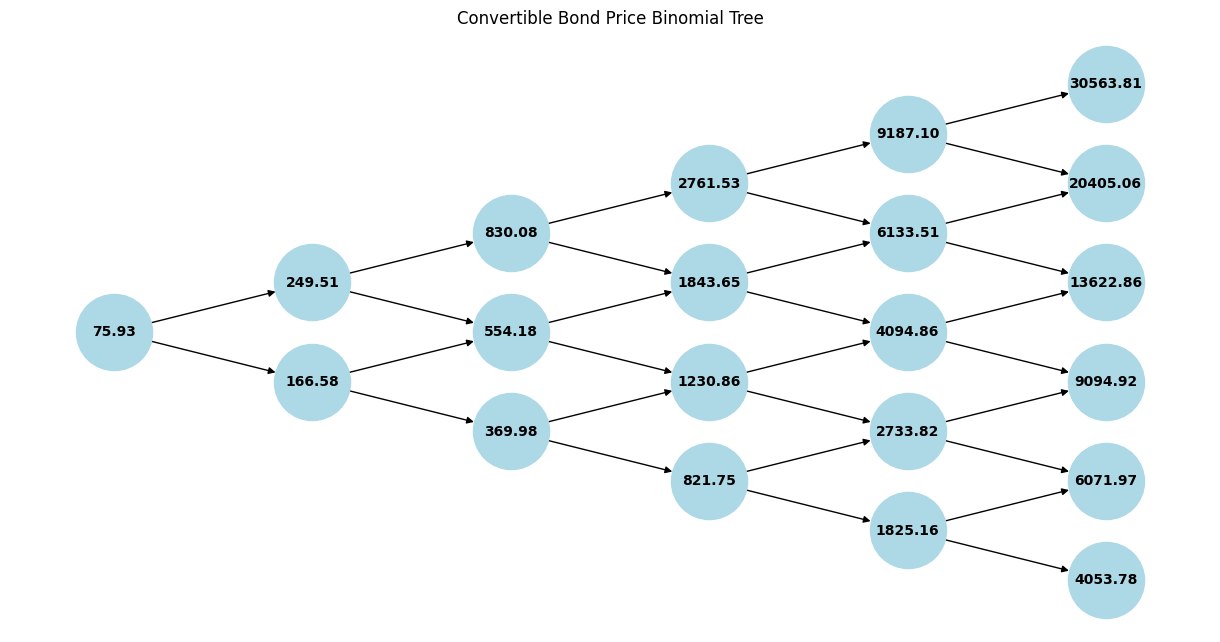

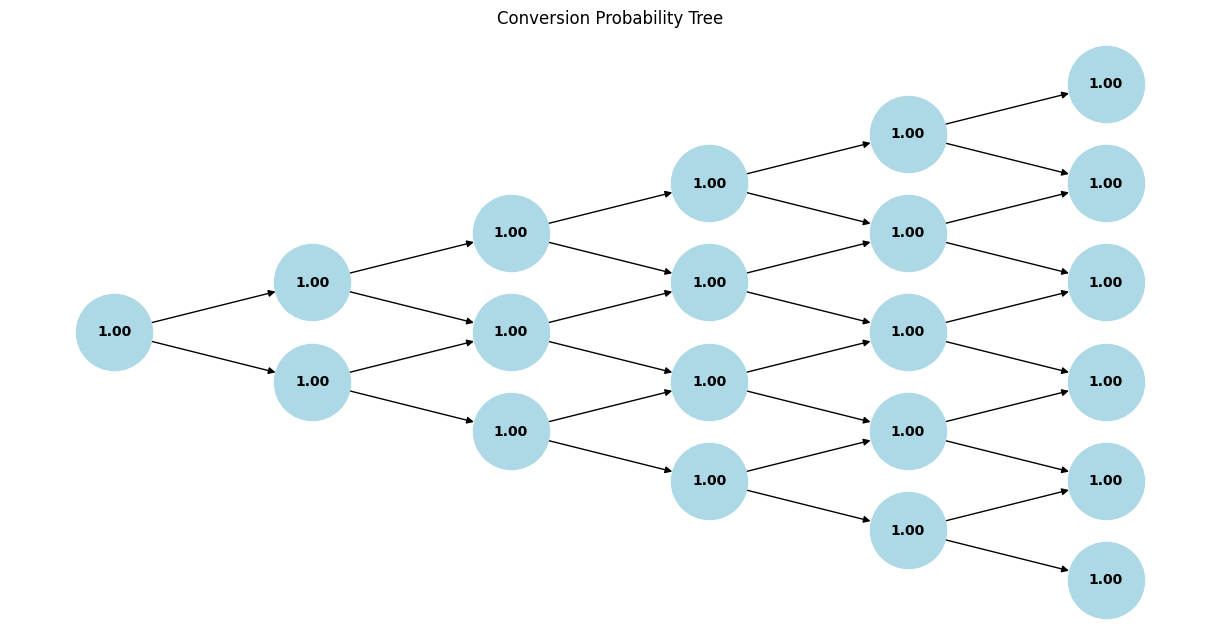

In [69]:
TreeType = 'Haahtela'                    # Specify the tree type ('CRR', 'Tian', 'EQP', etc.)

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Haahtela Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

model_types: ['CRR', 'EQP', 'Tian', 'CRR_Drift'], type: <class 'list'>


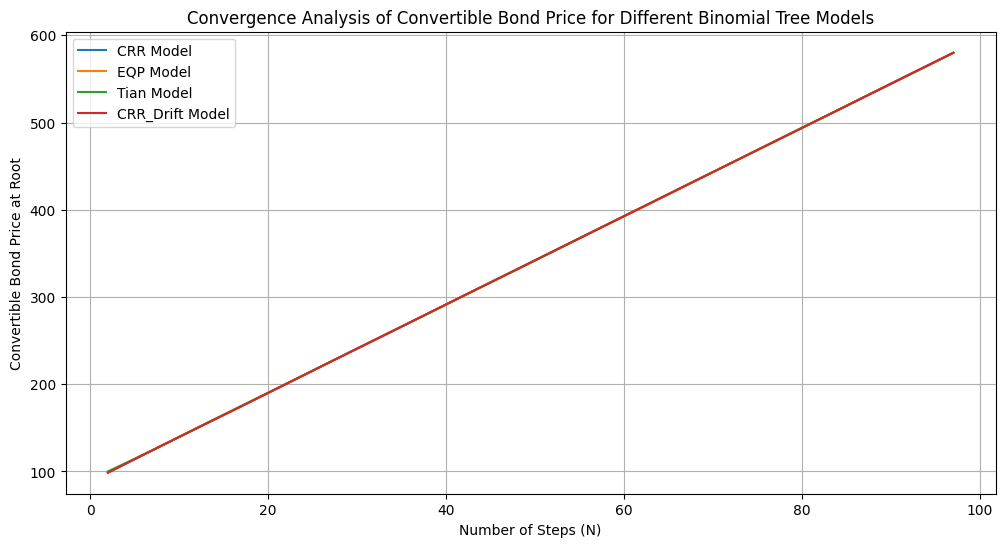

In [70]:
# Define the tree parameter calculation function
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'Tian':
        eta = np.exp(dt * sigma ** 2)
        u = 0.5 * np.exp((r - q) * dt) * eta * (eta + 1 + np.sqrt(eta ** 2 + 2 * eta - 3))
        d = 0.5 * np.exp((r - q) * dt) * eta * (eta + 1 - np.sqrt(eta ** 2 + 2 * eta - 3))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'EQP':
        u = np.exp(((r - q) - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt))
        d = np.exp(((r - q) - sigma ** 2 / 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'CRR_Drift':
        u = np.exp(drift * dt + sigma * np.sqrt(dt))
        d = np.exp(drift * dt - sigma * np.sqrt(dt))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    else:
        raise ValueError("Invalid model type specified.")
    return u, d, p

# Function to calculate bond price using the given model
def calculate_bond_price(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, model_type, drift=0):
    dt = T / steps
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Construct the stock price tree
    StockPrice = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))
    
    # Create bond price tree and conversion probability tree
    OptionValue = np.zeros((steps + 1, steps + 1))
    ConversionProbability = np.zeros((steps + 1, steps + 1))

    # Calculate values at maturity
    for i in range(steps + 1):
        OptionValue[i, steps] = max(F + coupon, conversion_ratio * StockPrice[i, steps])
        ConversionProbability[i, steps] = 1 if OptionValue[i, steps] == conversion_ratio * StockPrice[i, steps] else 0

    # Backward induction
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            ru = ConversionProbability[i + 1, j + 1] * r + (1 - ConversionProbability[i + 1, j + 1]) * (r + drift)
            rd = ConversionProbability[i, j + 1] * r + (1 - ConversionProbability[i, j + 1]) * (r + drift)
            OptionValue[i, j] = coupon + p * OptionValue[i + 1, j + 1] * np.exp(-ru * dt) + (1 - p) * OptionValue[i, j + 1] * np.exp(-rd * dt)
            ConversionProbability[i, j] = p * ConversionProbability[i + 1, j + 1] + (1 - p) * ConversionProbability[i, j + 1]

    return OptionValue[0, 0]

# Function to calculate convergence for different models
def calculate_convergence(S0, F, T, r, sigma, q, coupon, conversion_ratio, max_steps, model_types, drift=0):
    # Check the value and type of model_types before proceeding
    print(f"model_types: {model_types}, type: {type(model_types)}")
    
    # Initialize a dictionary to store prices for each tree type
    prices = {tree: [] for tree in model_types}
    steps_range = list(range(2, max_steps + 1, 5))  # Define step intervals (2, 7, 12, ..., max_steps)

    # Calculate bond prices for each tree type and each number of steps
    for steps in steps_range:
        for tree in model_types:
            price = calculate_bond_price(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, tree, drift)
            prices[tree].append(price)

    return steps_range, prices

# Function to plot the convergence results
def plot_convergence(steps_range, prices):
    plt.figure(figsize=(12, 6))
    for tree, price_list in prices.items():
        plt.plot(steps_range, price_list, label=f"{tree} Model")

    plt.xlabel("Number of Steps (N)")
    plt.ylabel("Convertible Bond Price at Root")
    plt.title("Convergence Analysis of Convertible Bond Price for Different Binomial Tree Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define input parameters
S0 = 75            # Initial stock price
F = 100            # Bond face value
T = 5              # Time to maturity in years
r = 0.07           # Risk-free rate
sigma = 0.2        # Volatility
q = 0              # Dividend yield
coupon = 6         # Annual coupon payment
conversion_ratio = 1   # Conversion ratio
max_steps = 100    # Maximum number of steps for convergence analysis

# Define models to test
model_types = ['CRR', 'EQP', 'Tian', 'CRR_Drift']

# Calculate convergence results for the specified tree types
step_range, convergence_results = calculate_convergence(S0, F, T, r, sigma, q, coupon, conversion_ratio, max_steps, model_types)

# Plot the convergence results
plot_convergence(step_range, convergence_results)
